In [ ]:
import numpy as np
import pandas as pd

import os
import re
import math
import random

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as L

from sklearn.model_selection import KFold

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

     |████████████████████████████████| 51kB 2.7MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)
REPLICAS = strategy.num_replicas_in_sync

In [ ]:
INC2019 = 0
INC2018 = 1
EXTA = 0

DIM = 256
IMAGE_SIZE= [DIM, DIM]

_epoches = [10, 20, 30, 40]
_initial_epoch = [0, 10, 20, 30]

TTA = 25

BATCH_SIZE = 16*strategy.num_replicas_in_sync

FOLDS = 5
idxT = []; idxV = []
LEN = np.arange(15)

SEED = 1000
AUTO = tf.data.experimental.AUTOTUNE
WEIGHTS = 'noisy-student'

effnet = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, efn.EfficientNetB4, efn.EfficientNetB5,
          efn.EfficientNetB6, efn.EfficientNetB7]

In [ ]:
GCS_PATH1 = 'gs://kds-dffc4fc041639d63f5cb739622149422dbd485d2bd7f66a514c67fae'
GCS_PATH2 = 'gs://kds-c85f3ec67d1d7853bb9f2b928a1d69ac62ae7d52146c54a65b69f5bb'
#GCS_PATH3 = 'gs://kds-d865e7070f63d0bbb2fe08d16db2b817cd02fc99a1eae9b2dc345ac0'

In [ ]:
train_1 = pd.read_csv('/content/gdrive/My Drive/kaggle/jpeg-melanoma-768x768/train.csv')
train_2 = pd.read_csv('/content/gdrive/My Drive/kaggle/jpeg-isic2019-768x768/train.csv')
#train_3 = pd.read_csv('/content/gdrive/My Drive/kaggle/siim-tabulardata/datasets_791638_1362855_train_malig_2.csv')

train = pd.DataFrame(pd.concat([train_1, train_2]))
Y = pd.DataFrame(pd.concat([train_1.target, train_2.target]))

In [ ]:
mean = train.age_approx.mean()
std = train.age_approx.std()

In [ ]:
def prepare_image(data, augment = False):
    image = data['CNN_inp']
    
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    
    if augment:
        image = transform(image)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_brightness(image, 0.1)
    
    data['CNN_inp'] = image
    return data

In [ ]:
tab_feats = [
    'sex',
    'age_approx',
]

N_TAB_FEATS = len(tab_feats)

def setup_input(image, label, data):
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in tab_feats]
    tabular = tf.stack(tab_data)
    return {'CNN_inp': image, 'TAB_inp':  tabular}, label

def setup_test_image(image, image_name, data):    
    tab_data = [tf.cast(data[tfeat], dtype = tf.float32) for tfeat in tab_feats]
    tabular = tf.stack(tab_data)
    return {'CNN_inp': image, 'TAB_inp':  tabular}, image_name

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string), # shape [] means single element
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
        "target": tf.io.FixedLenFeature([], tf.int64),  
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = example['image']
    label = tf.cast(example['target'], tf.float32)
    
    data = {}
    data['image_name'] = example['image_name']
    data['sex'] = tf.cast(example['sex'], tf.int64)
    data['age_approx'] = (tf.cast(example['age_approx'], tf.float32) - mean)/std
    
    return image, label, data

In [ ]:
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "sex": tf.io.FixedLenFeature([], tf.int64),
        "age_approx": tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    
    image = example['image']
    image_name = example['image_name']
    
    data = {}
    data['image_name'] = image_name
    data['sex'] = tf.cast(example['sex'], tf.int64)
    data['age_approx'] = (tf.cast(example['age_approx'], tf.float32) - mean)/std
    
    return image, image_name, data

In [ ]:
def get_dataset(files, augmented = False, shuffle = False, repeat = False, labeled = False):
    
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads = AUTO)
    dataset = dataset.cache()
    
    if repeat:
        dataset = dataset.repeat()
        
    if shuffle: 
        dataset = dataset.shuffle(1024)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        dataset = dataset.with_options(opt)
    
    if labeled:
        dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO)
        dataset = dataset.map(setup_input, num_parallel_calls = AUTO)
    else:
        dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls = AUTO)
        dataset = dataset.map(setup_test_image, num_parallel_calls = AUTO)
    
    dataset = dataset.map(lambda data, imagename_or_label : (prepare_image(data, augment = augmented), imagename_or_label),
                          num_parallel_calls = AUTO)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    
    return dataset

In [ ]:
####variables to set extent of image augmentation.
ROT_ = 90.0
HZOOM_ = 4.0
WZOOM_ = 4.0
HSHIFT_ = 4.0
WSHIFT_ = 4.0

def get_mat(rotation, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies

    def get_3x3_mat(mat):
        return tf.reshape(tf.concat([mat], axis = 0), [3, 3])
    
    # ROTATION MATRIX
    cos = tf.math.cos(rotation)
    sin = tf.math.sin(rotation)
    one = tf.constant([1], dtype = 'float32')
    zero = tf.constant([0], dtype = 'float32')
    
    rotation_matrix = get_3x3_mat([cos, sin ,zero,
                                   -sin, cos, zero,
                                   zero, zero, one])        
           
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero, zero,
                               zero, one/width_zoom, zero, 
                               zero, zero, one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one, zero, height_shift, 
                                zero, one, width_shift, 
                                zero, zero, one])
    
    return tf.keras.backend.dot(rotation_matrix, tf.keras.backend.dot(zoom_matrix, shift_matrix))

def transform(image):
    XDIM = DIM%2
    
    rot = ROT_*tf.random.uniform([1])
    rot = math.pi*rot/180.
    
    h_zoom = 1.0 + tf.random.normal([1], dtype = 'float32')/HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype = 'float32')/WZOOM_
    h_shift = HSHIFT_*tf.random.normal([1], dtype = 'float32') 
    w_shift = WSHIFT_*tf.random.normal([1], dtype = 'float32')
    
    m = get_mat(rot, h_zoom, w_zoom, h_shift, w_shift)

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM//2, -DIM//2, -1), DIM)
    y = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z = tf.ones([DIM*DIM], dtype = 'int32')
    idx = tf.stack([x,y,z])
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.keras.backend.dot(m, tf.cast(idx, dtype = 'float32'))
    idx2 = tf.keras.backend.cast(idx2, dtype = 'int32')
    idx2 = tf.keras.backend.clip(idx2, -DIM//2 + XDIM + 1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2 - idx2[0, ], DIM//2 - 1 + idx2[1,]])
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d, [DIM, DIM, 3])

In [ ]:
def get_training_dataset():
    dataset = get_dataset(TRAINING_FILENAMES,
                          augmented = True,
                          shuffle = True,
                          repeat = True,
                          labeled = True)
    return dataset

def get_validation_dataset():
    dataset = get_dataset(VALIDATION_FILENAMES,
                          augmented = False,
                          shuffle = False,
                          repeat = False,
                          labeled = True)
    return dataset

def get_test_dataset(ordered = True):
    dataset = get_dataset(TEST_FILENAMES,
                          augmented = True,
                          shuffle = False,
                          repeat = True,
                          labeled = False)
    return dataset

In [ ]:
neg, pos = np.bincount(Y.target)
pos = pos + EXTA

initial_bias = np.log(pos/neg)

weight_for_0 = (1 / neg)*(pos + neg)/2.0 
weight_for_1 = (1 / pos)*(pos + neg)/2.0
classweights = {0: weight_for_0, 1: weight_for_1}

In [ ]:
with strategy.scope():
    METRICS = [
      tf.keras.metrics.TruePositives(name = 'tp'),
      tf.keras.metrics.AUC(name = 'auc'),
    ]

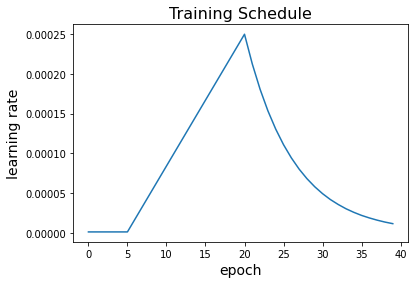

In [ ]:
lr_start = 1e-6
lr_max =   3.125e-5*REPLICAS
lr_min = 0.000001
start_epoch = 5
rampup_epoch = 20
sustain_epoch = 20
lr_exp_decay = 0.85

def lrfn(epoch):
    if epoch < start_epoch :
        lr = lr_start
    elif epoch < rampup_epoch :
        lr = ((lr_max - lr_start)/(rampup_epoch - start_epoch))*(epoch - start_epoch) + lr_start
    elif epoch < sustain_epoch :
            lr = lr_max
    else:
            lr = lr_max*(lr_exp_decay**(epoch - sustain_epoch) + lr_min)
            
    return round(lr, 7)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = 1)

rng = [i for i in range(40)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size = 14); plt.ylabel('learning rate',size = 14)
plt.title('Training Schedule', size = 16); plt.show()

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

def plot_metrics(history):
    metrics =  ['loss', 'auc']
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(1, 2, n + 1)
      
      plt.plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
      plt.plot(history.epoch, history.history['val_'+ metric], color = colors[0], linestyle = "--", label = 'Val')
      
      plt.xlabel('Epoch')
      plt.ylabel(name)
      
      if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
          
      elif metric == 'auc':
          plt.ylim([0.0,1])
          
      plt.legend()
      plt.tight_layout(pad = 5)
      plt.show()

In [ ]:
NET_SELECT = 6
num_str = 'model-b%i' %NET_SELECT

In [ ]:
%cd /content/gdrive/My Drive/kaggle/AllFoldsAllData_b6_256/


/content/gdrive/My Drive/kaggle/AllFoldsAllData_b6_256


In [ ]:
%ls

In [ ]:
def build_model():
    with strategy.scope():
        eff_model = effnet[NET_SELECT](
            input_shape = (*IMAGE_SIZE, 3),
            weights = WEIGHTS,
            include_top = False
        )

        eff_model.trainable = True
        
        CNN_inp = L.Input(shape = (*IMAGE_SIZE, 3), name = 'CNN_inp')
        TAB_inp = L.Input(shape = (N_TAB_FEATS), name = 'TAB_inp')
        
        x = eff_model(CNN_inp)
        x = L.GlobalMaxPooling2D()(x)
        x = L.Dense(1024, activation = 'relu')(x)
        x = L.Dropout(0.3)(x)
        x = L.Dense(512, activation = 'relu')(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(256, activation ='relu')(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(128, activation ='relu')(x)
        x = L.Dropout(0.1)(x)
        x = L.Dense(30, activation ='relu')(x)
        x = L.Dropout(0.1)(x)
        
        y = L.Dense(8, activation = 'relu')(TAB_inp)
        y = L.Dropout(0.1)(y)
        y = L.Dense(2, activation ='relu')(y)
        y = L.Dropout(0.1)(y)
        
        combine = L.concatenate([y, x])
        
        output = L.Dense(1, activation ='sigmoid',
                         bias_initializer = tf.keras.initializers.Constant(initial_bias),
                         name = 'output')(combine)
        
        model = tf.keras.models.Model(inputs = [CNN_inp, TAB_inp], outputs = [output])

        model.compile(
            optimizer = 'adam',
            loss = tfa.losses.SigmoidFocalCrossEntropy(gamma = 5.0, alpha = 0.2),
            metrics = METRICS
        )
    
    return model


model = build_model()
model.summary()

165232640/165226952 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN_inp (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b6 (Functional)    (None, 8, 8, 2304)   40960136    CNN_inp[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2304)         0           efficientnet-b6[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         2360320     global_max_pooling2d[0][0]       
____________________

Validation index:  [ 2  5 12]
Number of training files:  27
Dataset: 38989 training images, 6562 validation images, 10982 unlabeled test images



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


  2/304 [..............................] - ETA: 1:32 - loss: 0.1510 - tp: 0.0000e+00 - auc: 0.4096WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0243s vs `on_train_batch_end` time: 0.5877s). Check your callbacks.


304/304 [==============================] - 223s 735ms/step - loss: 0.0993 - tp: 47.0000 - auc: 0.5071 - val_loss: 0.0053 - val_tp: 1.0000 - val_auc: 0.4221

Epoch 00002: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 2/10
304/304 [==============================] - 192s 631ms/step - loss: 0.0575 - tp: 193.0000 - auc: 0.4932 - val_loss: 0.0040 - val_tp: 0.0000e+00 - val_auc: 0.4572

Epoch 00003: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 3/10
304/304 [==============================] - 193s 634ms/step - loss: 0.0493 - tp: 193.0000 - auc: 0.4885 - val_loss: 0.0033 - val_tp: 0.0000e+00 - val_auc: 0.4655

Epoch 00004: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 4/10
304/304 [==============================] - 193s 636ms/step - loss: 0.0439 - tp: 199.0000 - auc: 0.4860 - val_loss: 0.0031 - val_tp: 0.0000e+00 - val_auc: 0.4698

Epoch 00005: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 5/10
304/304 [==============================] 

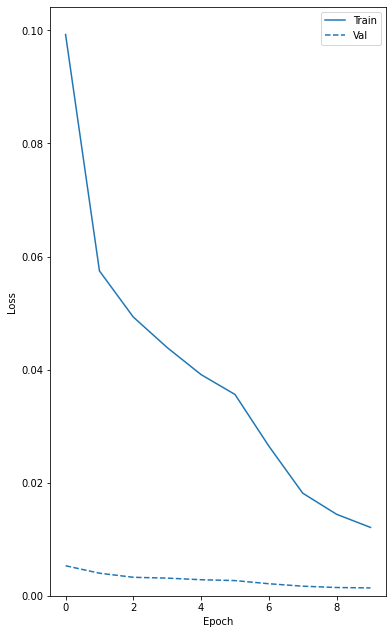

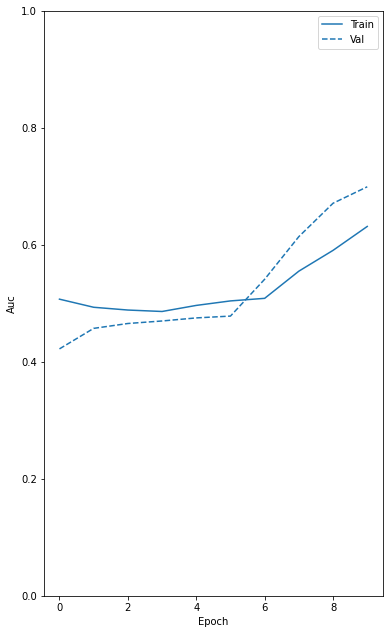

weights-0-05-0.475.h5  weights-0-10-0.699.h5  weights_fold-0_model-b6.h5
weights_fold-0_model-b6.h5
Validation index:  [ 6  9 14]
Number of training files:  27
Dataset: 39024 training images, 6527 validation images, 10982 unlabeled test images



Epoch 00011: LearningRateScheduler reducing learning rate to 8.4e-05.
Epoch 11/20
  2/304 [..............................] - ETA: 1:41 - loss: 0.0093 - tp: 2.0000 - auc: 0.6394WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0335s vs `on_train_batch_end` time: 0.6319s). Check your callbacks.


304/304 [==============================] - 193s 635ms/step - loss: 0.0109 - tp: 472.0000 - auc: 0.6586 - val_loss: 0.0013 - val_tp: 0.0000e+00 - val_auc: 0.7498

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0001006.
Epoch 12/20
304/304 [==============================] - 194s 640ms/step - loss: 0.0100 - tp: 497.0000 - auc: 0.6766 - val_loss: 0.0013 - val_tp: 0.0000e+00 - val_auc: 0.7809

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0001172.
Epoch 13/20
304/304 [==============================] - 194s 639ms/step - loss: 0.0092 - tp: 532.0000 - auc: 0.7081 - val_loss: 0.0012 - val_tp: 0.0000e+00 - val_auc: 0.7897

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0001338.
Epoch 14/20
304/304 [==============================] - 194s 639ms/step - loss: 0.0087 - tp: 570.0000 - auc: 0.7215 - val_loss: 0.0013 - val_tp: 0.0000e+00 - val_auc: 0.8022

Epoch 00015: LearningRateScheduler reducing learning rate to 0.0001504.
Epoch 15/20
304/304 [=======

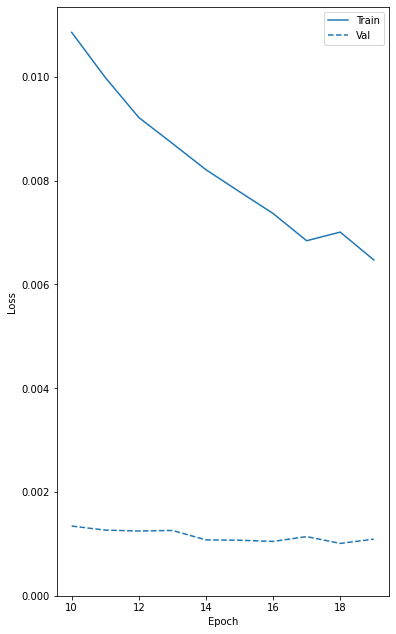

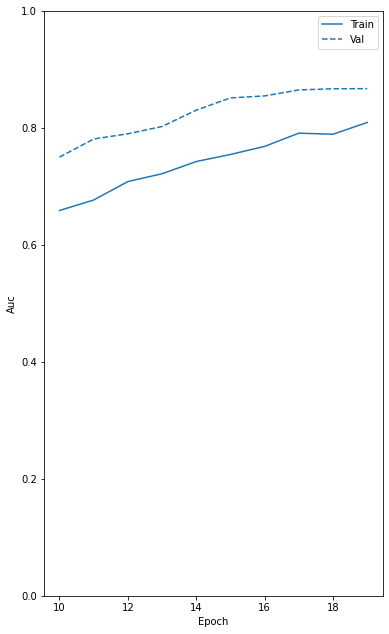

weights-0-05-0.475.h5  weights-1-15-0.830.h5  weights_fold-0_model-b6.h5
weights-0-10-0.699.h5  weights-1-20-0.867.h5  weights_fold-1_model-b6.h5
weights_fold-1_model-b6.h5
Validation index:  [ 4  8 10]
Number of training files:  27
Dataset: 39033 training images, 6518 validation images, 10982 unlabeled test images



Epoch 00021: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 21/30
  2/304 [..............................] - ETA: 1:45 - loss: 0.0076 - tp: 1.0000 - auc: 0.5541  WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0311s vs `on_train_batch_end` time: 0.6639s). Check your callbacks.


304/304 [==============================] - 202s 666ms/step - loss: 0.0065 - tp: 671.0000 - auc: 0.8042 - val_loss: 0.0013 - val_tp: 0.0000e+00 - val_auc: 0.8635

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0002125.
Epoch 22/30
304/304 [==============================] - 194s 639ms/step - loss: 0.0062 - tp: 737.0000 - auc: 0.8209 - val_loss: 0.0012 - val_tp: 0.0000e+00 - val_auc: 0.8653

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0001806.
Epoch 23/30
304/304 [==============================] - 194s 639ms/step - loss: 0.0060 - tp: 775.0000 - auc: 0.8296 - val_loss: 0.0012 - val_tp: 0.0000e+00 - val_auc: 0.8703

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0001535.
Epoch 24/30
304/304 [==============================] - 194s 638ms/step - loss: 0.0059 - tp: 730.0000 - auc: 0.8294 - val_loss: 0.0011 - val_tp: 0.0000e+00 - val_auc: 0.8716

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0001305.
Epoch 25/30
304/304 [=======

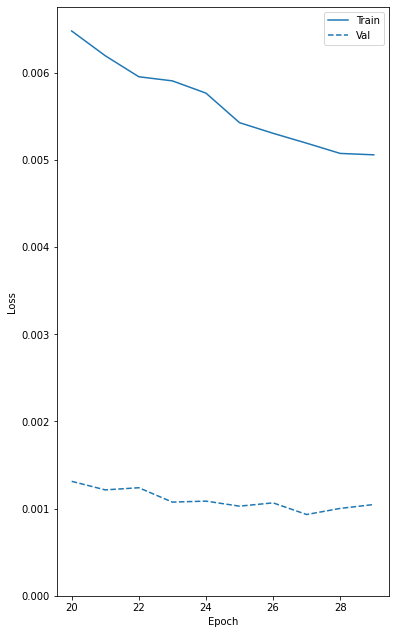

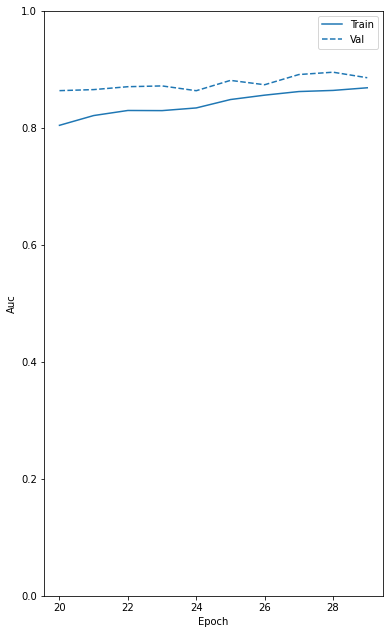

weights-0-05-0.475.h5  weights-1-20-0.867.h5  weights_fold-0_model-b6.h5
weights-0-10-0.699.h5  weights-2-25-0.863.h5  weights_fold-1_model-b6.h5
weights-1-15-0.830.h5  weights-2-30-0.886.h5  weights_fold-2_model-b6.h5
weights_fold-2_model-b6.h5
Validation index:  [ 0  1 11]
Number of training files:  27
Dataset: 39008 training images, 6543 validation images, 10982 unlabeled test images



Epoch 00031: LearningRateScheduler reducing learning rate to 4.92e-05.
Epoch 31/40
  2/304 [..............................] - ETA: 1:48 - loss: 0.0051 - tp: 1.0000 - auc: 0.5853WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0270s vs `on_train_batch_end` time: 0.6846s). Check your callbacks.


304/304 [==============================] - 200s 657ms/step - loss: 0.0049 - tp: 863.0000 - auc: 0.8705 - val_loss: 9.3800e-04 - val_tp: 0.0000e+00 - val_auc: 0.9215

Epoch 00032: LearningRateScheduler reducing learning rate to 4.18e-05.
Epoch 32/40
304/304 [==============================] - 194s 639ms/step - loss: 0.0049 - tp: 875.0000 - auc: 0.8754 - val_loss: 0.0010 - val_tp: 0.0000e+00 - val_auc: 0.9293

Epoch 00033: LearningRateScheduler reducing learning rate to 3.56e-05.
Epoch 33/40
304/304 [==============================] - 194s 638ms/step - loss: 0.0049 - tp: 895.0000 - auc: 0.8755 - val_loss: 9.3763e-04 - val_tp: 0.0000e+00 - val_auc: 0.9253

Epoch 00034: LearningRateScheduler reducing learning rate to 3.02e-05.
Epoch 34/40
304/304 [==============================] - 196s 646ms/step - loss: 0.0048 - tp: 874.0000 - auc: 0.8801 - val_loss: 9.5432e-04 - val_tp: 0.0000e+00 - val_auc: 0.9223

Epoch 00035: LearningRateScheduler reducing learning rate to 2.57e-05.
Epoch 35/40
304/304 

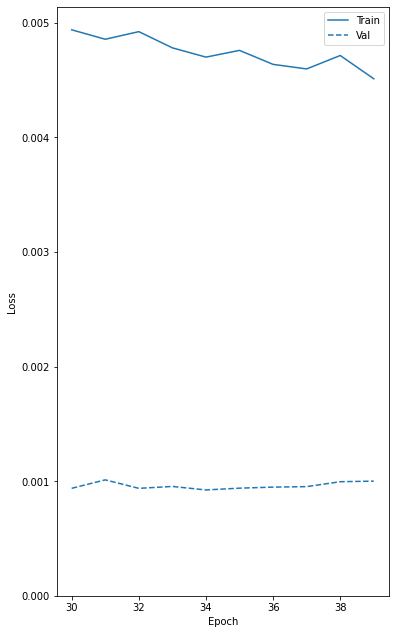

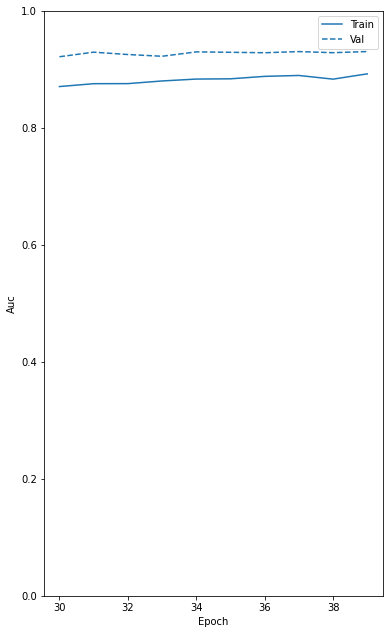

   2/2144 [..............................] - ETA: 4:17:17WARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0118s vs `on_predict_batch_end` time: 0.1087s). Check your callbacks.


2145/2144 [==============================] - 245s 114ms/step
        image_name    target
9905  ISIC_0052060  0.182490
1443  ISIC_0052349  0.174312
3120  ISIC_0058510  0.182669
4870  ISIC_0073313  0.175042
5494  ISIC_0073502  0.214829
...            ...       ...
5994  ISIC_9992485  0.191111
3980  ISIC_9996992  0.277185
6974  ISIC_9997917  0.233295
1278  ISIC_9998234  0.175703
3384  ISIC_9999302  0.241601

[10982 rows x 2 columns]
history_fold-3_model-b6.csv      weights-2-30-0.886.h5
submission-3-model-b6TTA_25.csv  weights-3-35-0.930.h5
weights-0-05-0.475.h5            weights-3-40-0.930.h5
weights-0-10-0.699.h5            weights_fold-0_model-b6.h5
weights-1-15-0.830.h5            weights_fold-1_model-b6.h5
weights-1-20-0.867.h5            weights_fold-2_model-b6.h5
weights-2-25-0.863.h5            weights_fold-3_model-b6.h5


In [ ]:
for i in range(4):  
    FOLD_SELECT = i

    if FOLD_SELECT > 0:
        weightfilepath = 'weights_fold-%i_' %(FOLD_SELECT - 1) + num_str + '.h5'
        print(weightfilepath)
        model.load_weights(weightfilepath)

    skf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for fold,(idx_t,idx_val) in enumerate(skf.split(np.arange(15))):
        if fold == FOLD_SELECT:
            idxT = idx_t
            idxV = idx_val
    print('Validation index: ', idxV)

    TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/train%.2i*.tfrec' %x for x in idxT)
    VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/train%.2i*.tfrec' %x for x in idxV)
    TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH1 + '/test*.tfrec')

    ####Additional training data
    #TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH3 + '/train%.2i*.tfrec' %x for x in range(15, 30)])
    if INC2019: TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH2 + '/train%.2i*.tfrec' %x for x in LEN*2 + 1])
    if INC2018: TRAINING_FILENAMES += tf.io.gfile.glob([GCS_PATH2 + '/train%.2i*.tfrec'%x for x in LEN*2])

    print('Number of training files: ', len(TRAINING_FILENAMES))

    NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
    NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
    NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
    print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES,
                                                                                              NUM_VALIDATION_IMAGES,
                                                                                              NUM_TEST_IMAGES))

    EPOCHS = _epoches[FOLD_SELECT]
    INITIAL_EPOCH = _initial_epoch[FOLD_SELECT]
    STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

    checkpoint_path = 'weights-%i-{epoch:02d}-{val_auc:.3f}.h5'%FOLD_SELECT
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor = 'val_auc',
                                                    verbose = 1,
                                                    save_weights_only = True,
                                                    period = 5)

    history = model.fit(
        get_training_dataset(), 
        epochs = EPOCHS, 
        initial_epoch = INITIAL_EPOCH,
        steps_per_epoch = STEPS_PER_EPOCH,
        class_weight = classweights,
        validation_data = get_validation_dataset(),
        callbacks = [lr_schedule, checkpoint]
    )

    model.save_weights('weights_fold-%i_' %FOLD_SELECT + num_str + '.h5')

    plot_metrics(history)

    if FOLD_SELECT == 3:
        pd.DataFrame.from_dict(history.history).to_csv('history_fold-%i_' %FOLD_SELECT + num_str + '.csv', index = False)

        STEPS = TTA*NUM_TEST_IMAGES/BATCH_SIZE
        testtf = get_test_dataset()
        test_images_ds = testtf.map(lambda data, image_name : data)

        pred = model.predict(test_images_ds, steps = STEPS, verbose = 1)[:TTA*NUM_TEST_IMAGES, ] 

        preds = np.zeros((NUM_TEST_IMAGES, 1))
        preds[:, 0] = np.mean(pred.reshape((NUM_TEST_IMAGES, TTA), order = 'F'), axis = 1)

        test_ids_ds = testtf.map(lambda image, image_name : image_name).unbatch()
        test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

        submission = pd.DataFrame(dict(image_name = test_ids, target = preds[:, 0]))
        submission = submission.sort_values('image_name') 
        submission.to_csv('submission-%i-' %FOLD_SELECT + num_str + 'TTA_25.csv' , index = False)
        print(submission)

    %ls